### It's dangerous to go alone! Take this.

Ptychography relies on the redundant information in overlapping probe positions to constrain the reconstructed object. It follows that the reconstruction quality is very sensitive on the extent of probe overlap.  
Unfortunately, there's no single number to quantify this - as  it depends on other experimental parameters such as probe aberrations.

In this tutorial notebook, we make some observations and provide tools which we hope will be useful to practisioners during data acquisition.

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Updated 2023 July 12

In [1]:
import numpy as np
import py4DSTEM
print(py4DSTEM.__version__)

0.14.2


## Experimental Design Parameters

There are 4 main experimental parameters to consider when recording/simulating 4DSTEM data for ptychography:
- Defocus
- Scan (real-space) step size
- Maximum scattering angle
- \# of detector pixels

The first two determine the extent of probe overlap.  
The maximum scattering angle sets the reconstruction pixel-size (ptychography can indeed achieve superresolution due to the use of subpixel probe shifts, but this is a good estimate of resolution).  
The \# of detector pixels determines the size of the array used to store the moving-window probe. This has to be large enough to fit the defocused probe w/o wrap-around artifacts.

You can get a sense of these parameters using a dummy dataset below:

In [2]:
def dummy_dataset_preprocess(
    defocus,
    scan_step_size_ang,
    maximum_scattering_angle_mrad,
    num_detector_pixels,
    sx=15,sy=15,energy=80e3,semiangle_cutoff=20,object_padding_px=None,
):
    """
    """
    
    if object_padding_px is None:
        object_padding_px = (num_detector_pixels//4,num_detector_pixels//4)
    
    dummy_data = np.ones((sx,sy,num_detector_pixels,num_detector_pixels))
    dc = py4DSTEM.DataCube(dummy_data)
    dc.calibration.set_R_pixel_size(scan_step_size_ang)
    dc.calibration.set_R_pixel_units('A')
    dc.calibration.set_Q_pixel_size(2*maximum_scattering_angle_mrad/num_detector_pixels)
    dc.calibration.set_Q_pixel_units('mrad')
    
    ptycho = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
        datacube=dc,
        verbose=False,
        energy=energy,
        semiangle_cutoff=semiangle_cutoff,
        defocus=defocus,
        object_padding_px=object_padding_px,
    ).preprocess(
        force_com_rotation=0,
        force_com_transpose=False,
        plot_rotation=False,
        plot_center_of_mass = False,
    )
    print(f"Reconstruction pixel size: {ptycho.sampling[0]:.4} A")
    print(f"Reconstruction object size: {ptycho.object_cropped.shape} px")

    return ptycho

Let's start playing around with this!
The following dataset does not have sufficient probe overlap:

Reconstruction pixel size: 0.261 A
Reconstruction object size: (136, 136) px


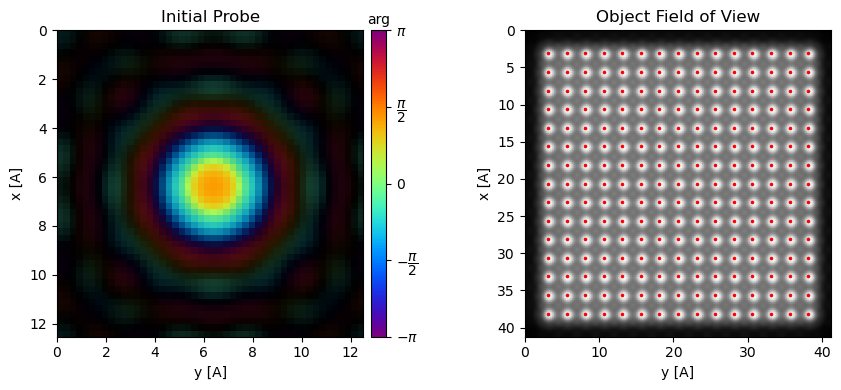

In [3]:
ptycho_not_enough_overlap = dummy_dataset_preprocess(
    100, # ang
    2.5, # ang
    80,  # mrad
    48,  # pixels
)

This can be remedied one of two ways:  
1. Decreasing the scan step-size (which restricts the field of view)

Reconstruction pixel size: 0.261 A
Reconstruction object size: (54, 54) px


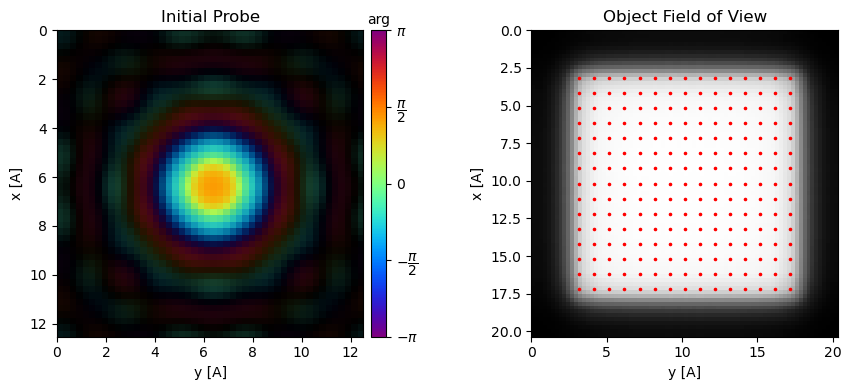

In [4]:
ptycho_enough_overlap_small_fov = dummy_dataset_preprocess(
    100, # ang
    1.0, # ang
    80,  # mrad
    48,  # pixels
)

2. Increasing the defocus

Reconstruction pixel size: 0.261 A
Reconstruction object size: (136, 136) px


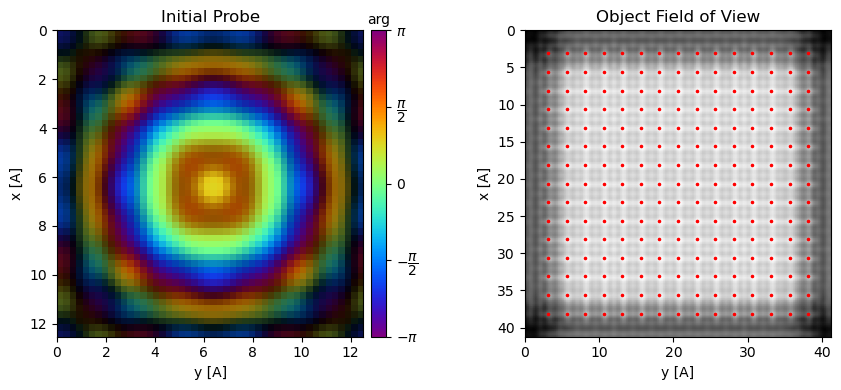

In [5]:
ptycho_enough_overlap_probe_artifacts = dummy_dataset_preprocess(
    300, # ang
    2.5, # ang
    80,  # mrad
    48,  # pixels
)

Notice however how our probe no-longer fits in a (48,48) array - leading to wrap-around artifacts.  
This can be remedied using more detector pixels.

Reconstruction pixel size: 0.261 A
Reconstruction object size: (136, 136) px


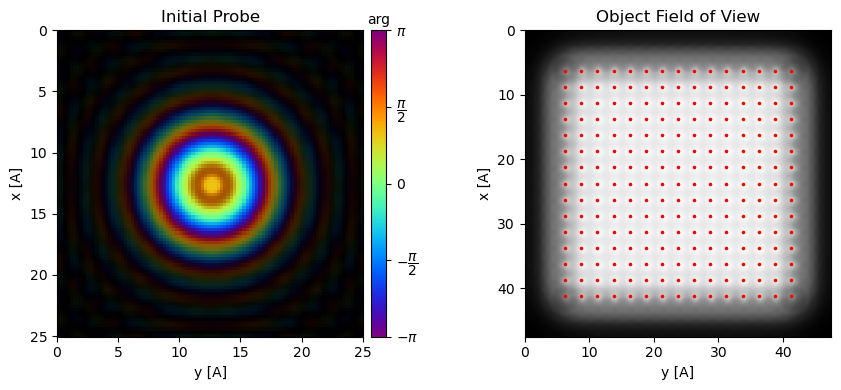

In [6]:
ptycho_enough_overlap = dummy_dataset_preprocess(
    300, # ang
    2.5, # ang
    80,  # mrad
    96,  # pixels
)

The above might appear as a moot point, considering most detectors have a fixed number of pixels anyway. However, in ptychographic reconstructions we often want to bin the 4DSTEM data to increase our signal-to-noise ratio/dynamic range as-well as for computational efficiency. 

Finally, let's see the effect of the maximum scattering angle on our setup:

Reconstruction pixel size: 0.522 A
Reconstruction object size: (69, 69) px


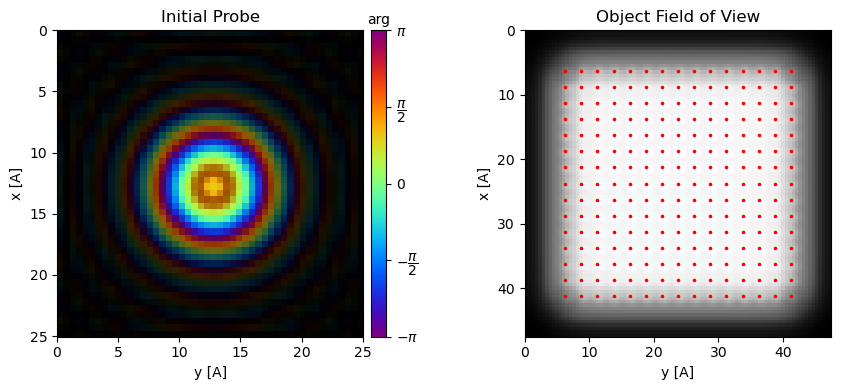

In [7]:
ptycho_enough_overlap_lower_resolution = dummy_dataset_preprocess(
    300, # ang
    2.5, # ang
    40,  # mrad
    48,  # pixels
)

We can achieve the same setup as above, by using only (48,48) detector pixels by using half the maximum scattering angle. However, notice that our reconstruction pixel size is now twice as large and thus our resolution will likely suffer.  

In general, you should only simulate/collect data up to scattering angles you have sufficient counts in. In detectors with a small dynamic range, this is often restricted to the bright field disk. In detectors with a large dynamic range, collecting to higher angles (so called "dark" electrons) enables super-resolution.

## Atomic Models Simulation

Like we hinted to above, the parameters above will depend on your target resolution. Atomic-resolution imaging of crystalline samples requires very different parameters than nanometer-resolution imaging of biological samples.  

It is therefore a good idea to run a quick simulation of your system before collecting data.  The idea is not to capture the intricacies of your sample (which may include defects, surfaces etc.), but rather to ensure that the reconstruction can capture the spatial frequencies of interest.

Below, we use abtem to simulate one such example for a Si [110] sample.

### Atomic Model

In [8]:
import abtem
import matplotlib.pyplot as plt

from ase.io import read
from ase.build import surface
from abtem.noise import poisson_noise

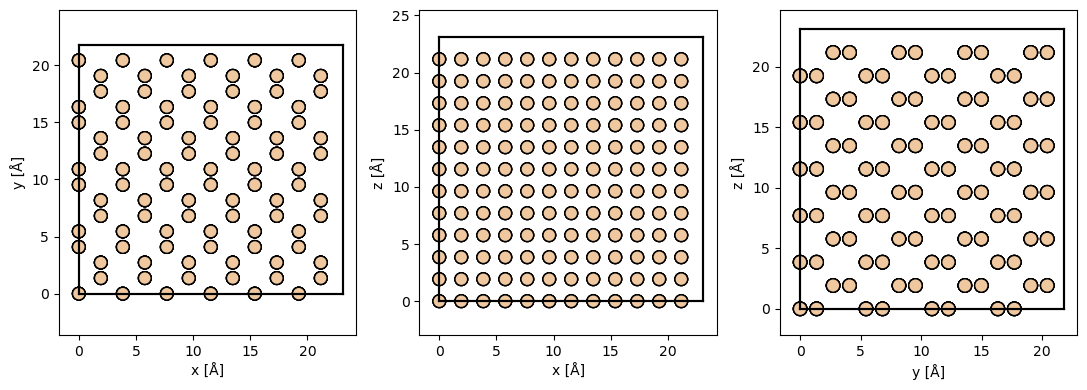

In [9]:
Si_unit_cell = read("data/Si.cif")
Si_atoms = surface(Si_unit_cell, (1, 1, 0), 6, periodic=True) * (3, 4, 1)
Si_atoms.wrap()


fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(11,4))

abtem.show_atoms(Si_atoms,plane='xy',ax=ax1)
abtem.show_atoms(Si_atoms,plane='xz',ax=ax2)
abtem.show_atoms(Si_atoms,plane='yz',ax=ax3)

fig.tight_layout()

### Simulation

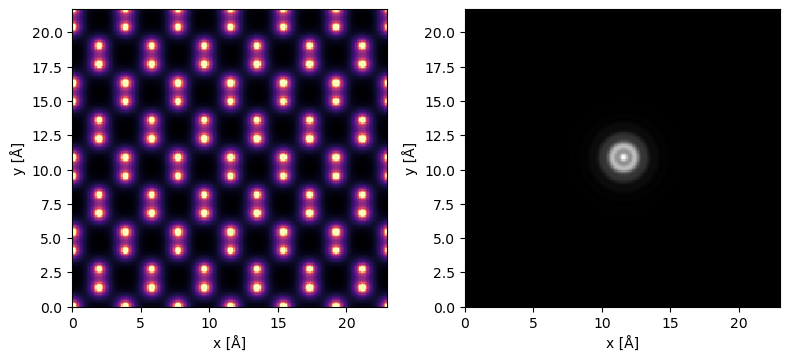

In [10]:
energy = 200e3 # volts
semiangle_cutoff = 20 # mrad
defocus = 100 # ang

potential = abtem.Potential(
    Si_atoms,
    sampling=0.1,
    #device="gpu",
    projection="infinite",
    parametrization="kirkland",
)

probe = abtem.Probe(
    semiangle_cutoff=semiangle_cutoff,
    energy=energy,
    defocus=defocus,
    #device="gpu"
)
probe.match_grid(potential)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

potential.project().show(ax=ax1,cmap='magma',vmax=1/abtem.utils.energy2sigma(energy))
probe.show(ax=ax2)

fig.tight_layout()

In [11]:
num_detector_pixels = 48 # px
maximum_scattering_angle_mrad = 60 # mrad
scan_step_size = 2.0 # ang

resample = 2*maximum_scattering_angle_mrad/(num_detector_pixels-2) # finicky parameter you might need to adjust if measurement has the wrong size. Due to ceil inside abtem's resampling
pixelated_detector = abtem.PixelatedDetector(
    max_angle=maximum_scattering_angle_mrad,
    resample=(resample,resample)
)

gridscan = abtem.GridScan(
    (0,0),
    potential.extent,
    sampling=scan_step_size,
    endpoint=True
)

measurement = probe.scan(gridscan, pixelated_detector, potential)

Potential:   0%|          | 0/47 [00:00<?, ?it/s]

Scan:   0%|          | 0/156 [00:00<?, ?it/s]

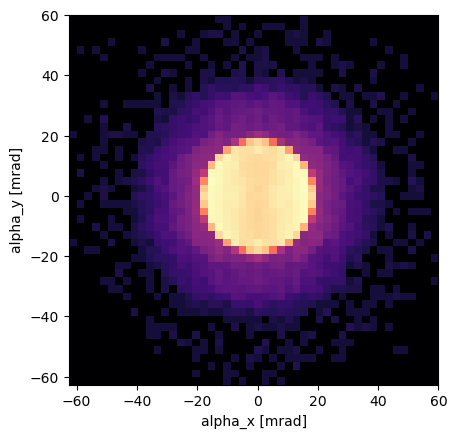

In [12]:
electron_dose = 1e4 # e/A^2

measurement_noise = poisson_noise(measurement, electron_dose)
measurement_noise.mean((0,1)).show(power=0.25,cmap='magma');

### Reconstruction

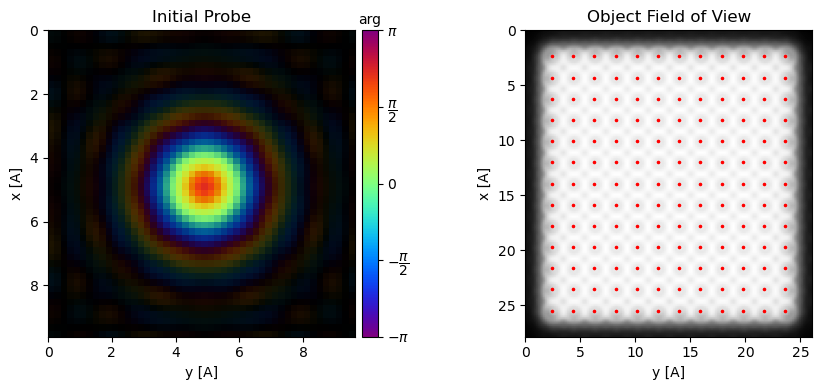

In [13]:
dc = py4DSTEM.DataCube(measurement_noise.array)
dc.calibration.set_R_pixel_size(measurement_noise.calibrations[0].sampling)
dc.calibration.set_R_pixel_units('A')
dc.calibration.set_Q_pixel_size(measurement_noise.calibrations[-1].sampling)
dc.calibration.set_Q_pixel_units('mrad')
dc.calibration

ptycho = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=dc,
    verbose=False,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    defocus=defocus,
    #device='gpu',
    object_padding_px=(num_detector_pixels//4,num_detector_pixels//4),
    object_type='potential',
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_rotation=False,
    plot_center_of_mass = False,
)

Reconstructing object and probe: 100%|████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 162.57 iter/s]


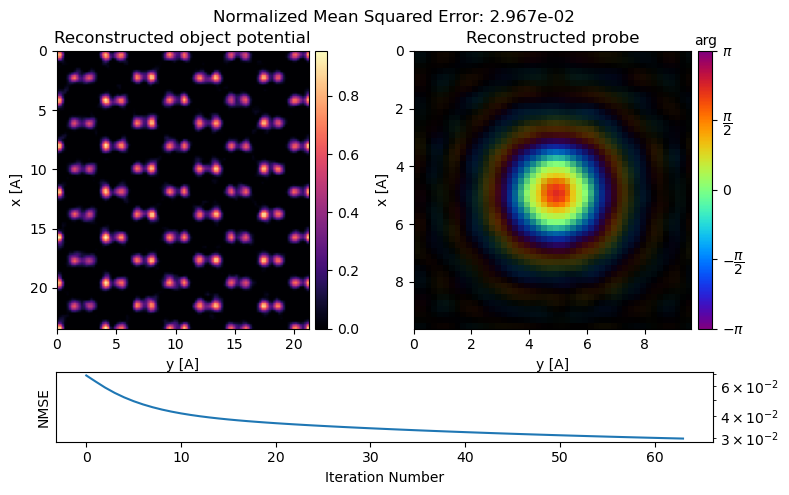

In [14]:
ptycho = ptycho.reconstruct(
    max_iter = 64,
    step_size=0.125,
    reset=True,
).visualize()